In [8]:
library(data.table)
library(Seurat)
library(SeuratWrappers)
library(ggplot2)
library(RColorBrewer)

In [121]:
# run data analysis
source('./R/CRC_analysis.R')

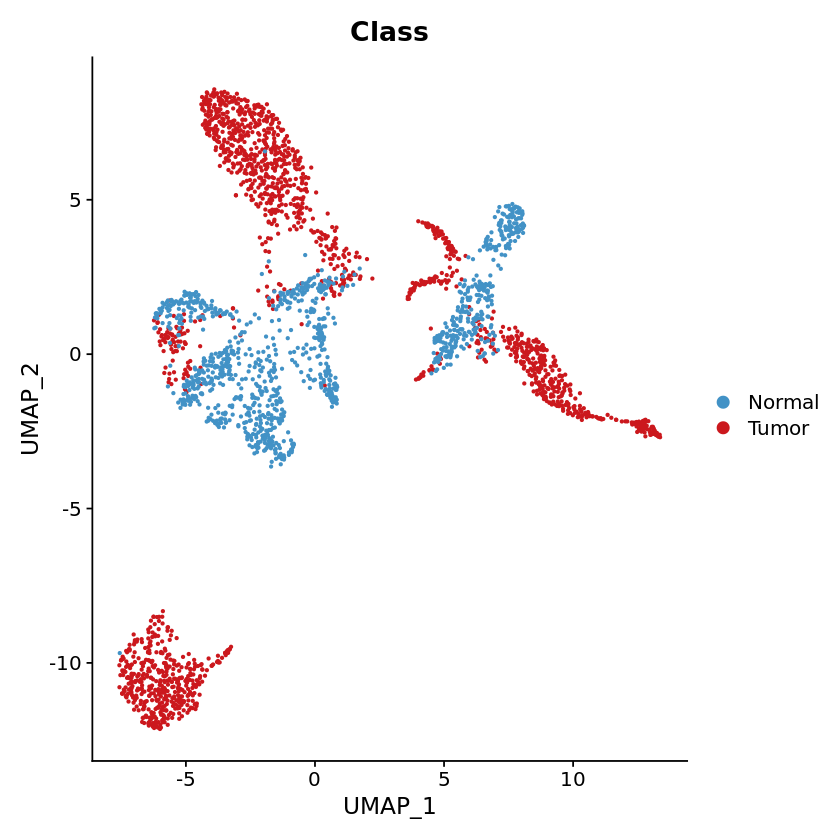

In [29]:
options(repr.plot.width = 7, repr.plot.height = 7)
DimPlot(crc, reduction = 'te.umap', group.by = 'Class', cols = c(brewer.pal(9,'Blues')[6], brewer.pal(9,'Reds')[7]))

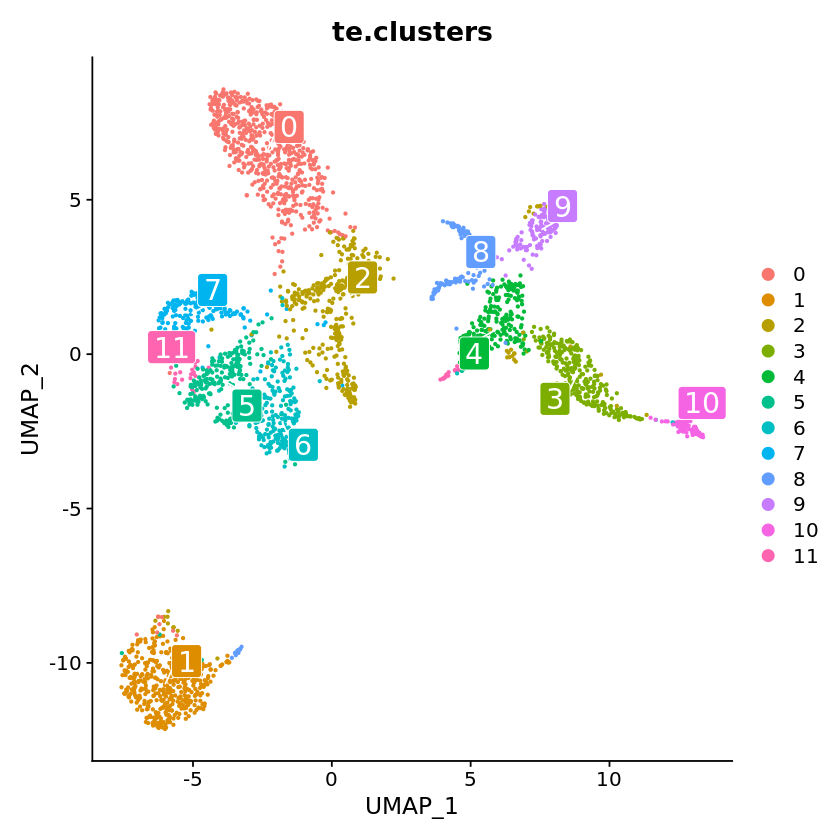

In [ ]:
options(repr.plot.width = 7, repr.plot.height = 7)
DimPlot(crc, reduction = 'te.umap', group.by = 'te.clusters',
                     label = TRUE, label.box = T, label.size = 6, repel = T, label.color = 'white')

In [28]:
crc@meta.data$te.clusters <- sub('^1$','K6',sub('^3$','K5',sub('^10$','K4',sub('^11$','K3',sub('^0$','K2',sub('^8$','K1',sub('^7$','N6',sub('^2$','N5',sub('^4$','N4',sub('^5$','N3',sub('^6$','N2',sub('^9$','N1',crc@meta.data$te.clusters))))))))))))

In [29]:
clusters <- as.data.table(crc@meta.data)[, .(count = .N), .(Class,Cell_subtype,te.clusters)][, prop := count/sum(count), te.clusters][]

In [33]:
clusters_ordered <- clusters[, sum(prop), .(te.clusters,Class)][order(Class, V1, decreasing = TRUE), unique(as.character(te.clusters))]

In [35]:
clusters[, te.clusters := factor(te.clusters, clusters_ordered)]
crc@meta.data$te.clusters <- factor(crc@meta.data$te.clusters, clusters_ordered)

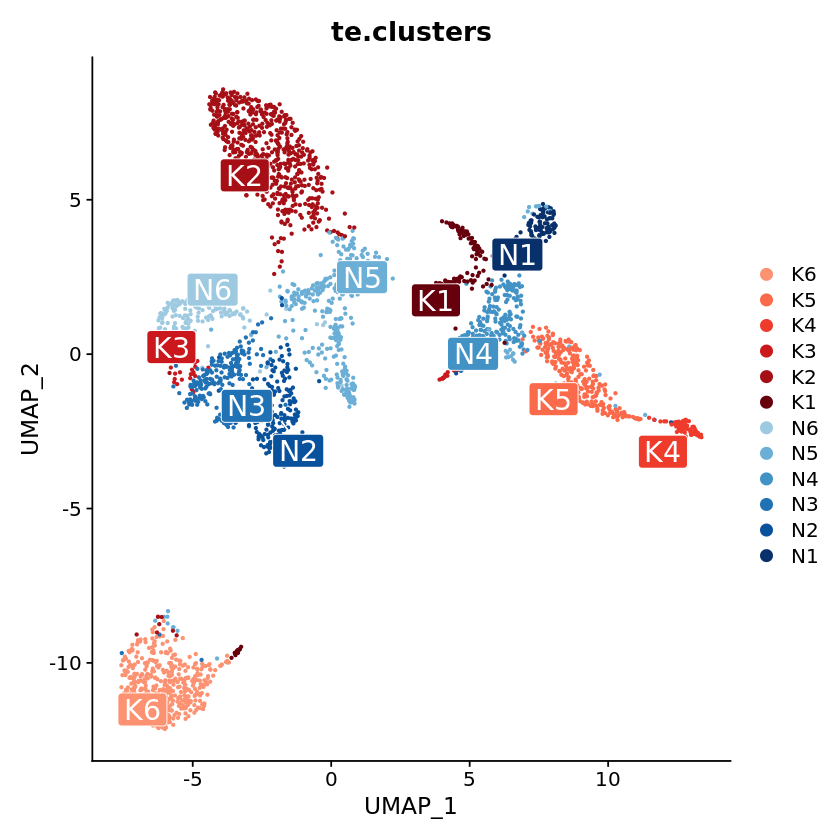

In [36]:
options(repr.plot.width = 7, repr.plot.height = 7)
DimPlot(crc, reduction = 'te.umap', group.by = 'te.clusters',
                     label = TRUE, label.box = T, label.size = 6, repel = T, label.color = 'white',
       cols = c(brewer.pal(9,'Reds')[4:9], brewer.pal(9,'Blues')[4:9]))

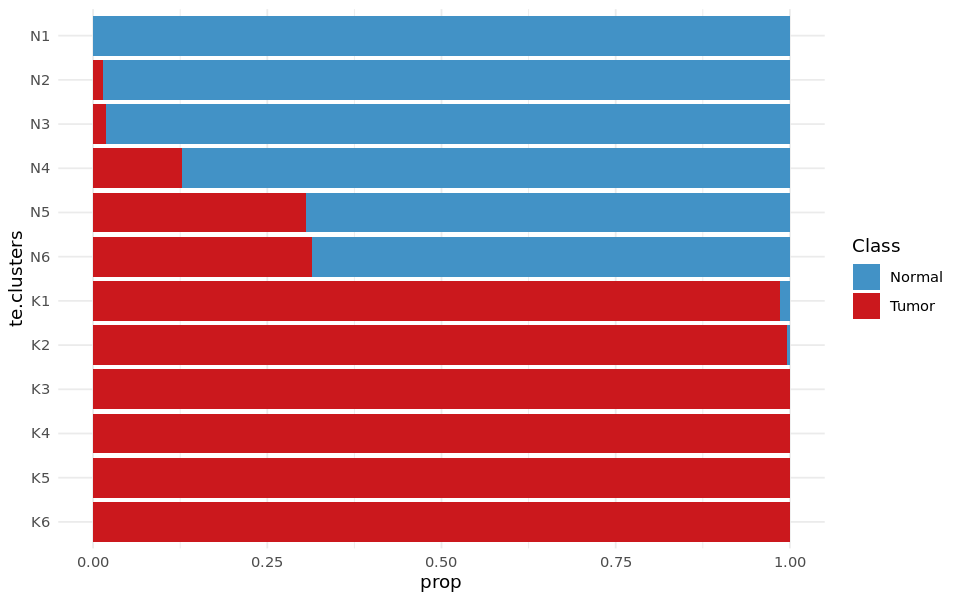

In [37]:
options(repr.plot.width = 8, repr.plot.height = 5)
ggplot(clusters, aes(x = te.clusters, y = prop, fill = Class)) +
geom_col() +
scale_fill_manual(values = c(brewer.pal(9,'Blues')[6], brewer.pal(9,'Reds')[7])) +
coord_flip() +
theme_minimal()

In [39]:
Idents(crc) <- 'te.clusters'
cluster_markers <- as.data.table(RunPrestoAll(crc, assay = 'TE', only.pos = TRUE, verbose = FALSE), keep.rownames = 'te')

In [107]:
Ksignature <- cluster_markers[avg_log2FC>=1 & p_val_adj<=0.1][, .(c = paste(cluster, collapse = "_")), gene][!grep("N", c, perl = TRUE), gene]

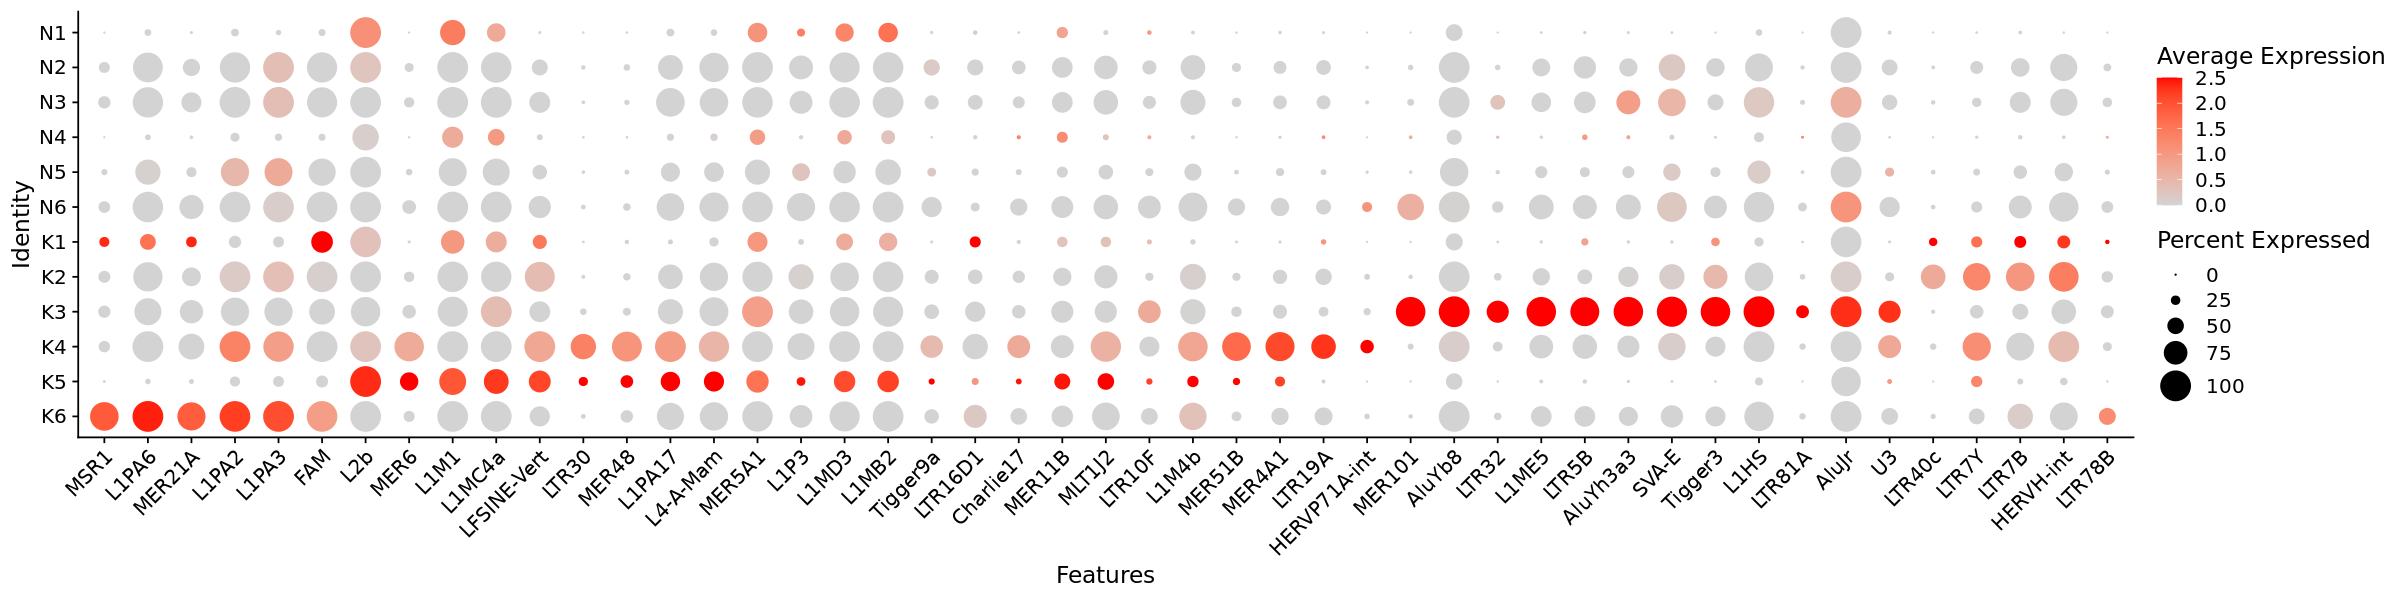

In [41]:
options(repr.plot.width = 20, repr.plot.height = 5)
DotPlot(crc, assay = 'TE', col.min = 0, cols = c('lightgrey','red'), dot.scale = 8, group.by = 'te.clusters', features = Ksignature) + RotatedAxis()

In [108]:
Nsignature <- cluster_markers[avg_log2FC>=1 & p_val_adj<=0.1][, .(c = paste(cluster, collapse = "_")), gene][!grep("K", c, perl = TRUE), gene]

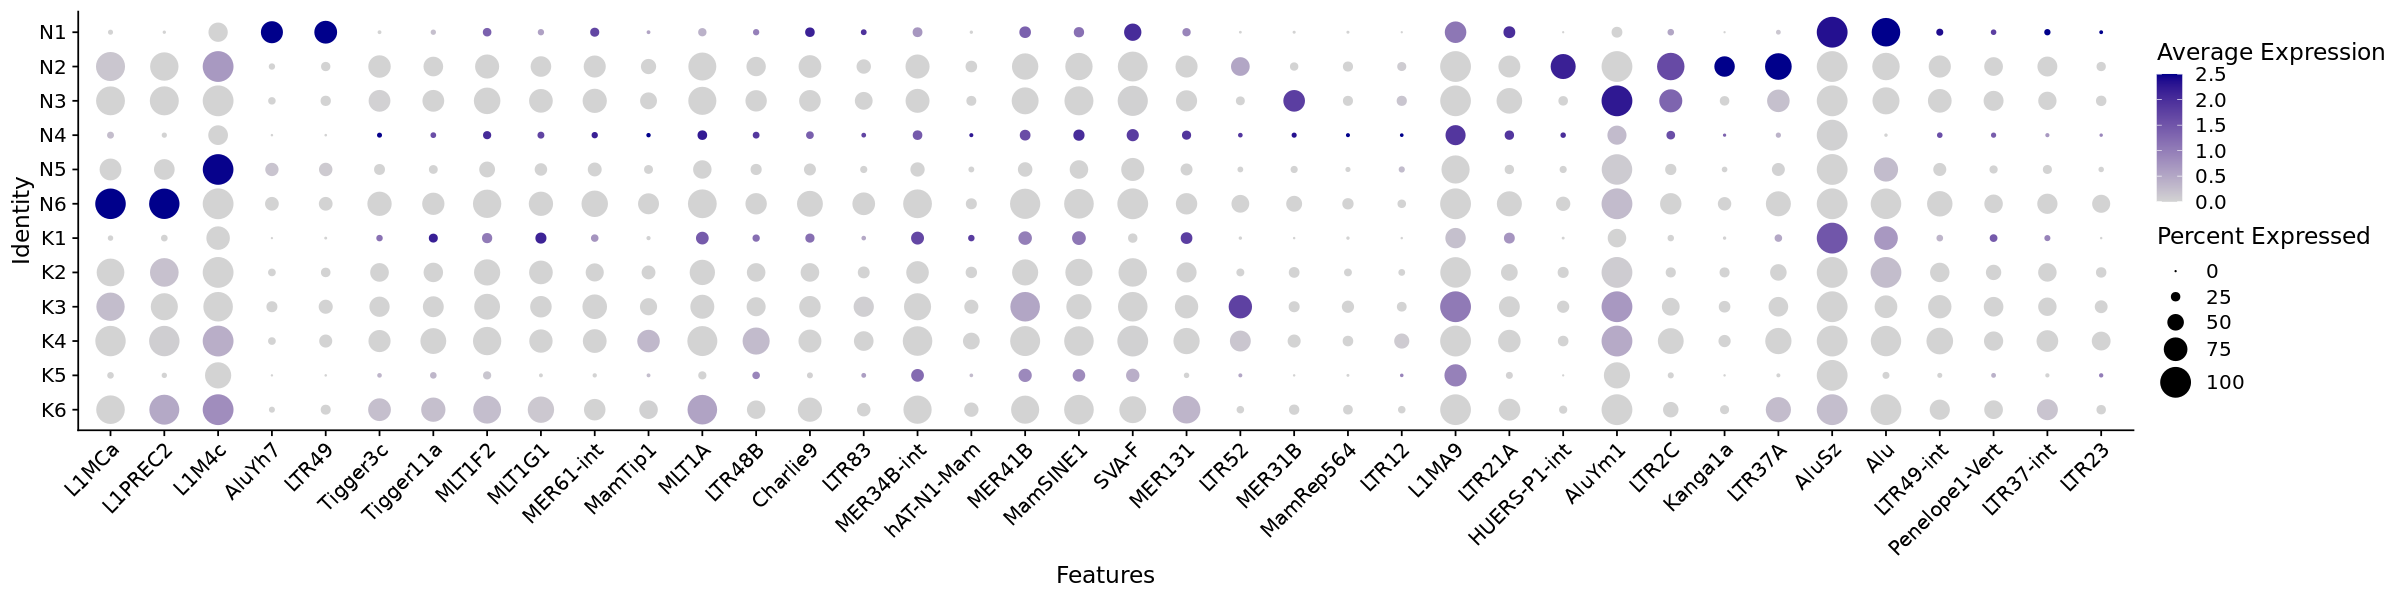

In [43]:
options(repr.plot.width = 20, repr.plot.height = 5)
DotPlot(crc, assay = 'TE', col.min = 0, cols = c('lightgrey','darkblue'), dot.scale = 8, group.by = 'te.clusters', features = Nsignature) + RotatedAxis()

In [50]:
signtable <- tetable[ subfamily %in% c(Ksignature, Nsignature) ]
signtable[, identity := ifelse(subfamily %in% Ksignature, 'Tumor', 'Normal')]
signtable <- signtable[, .(count = .N), .(class, identity)][, prop := count/sum(count), .(identity)][]

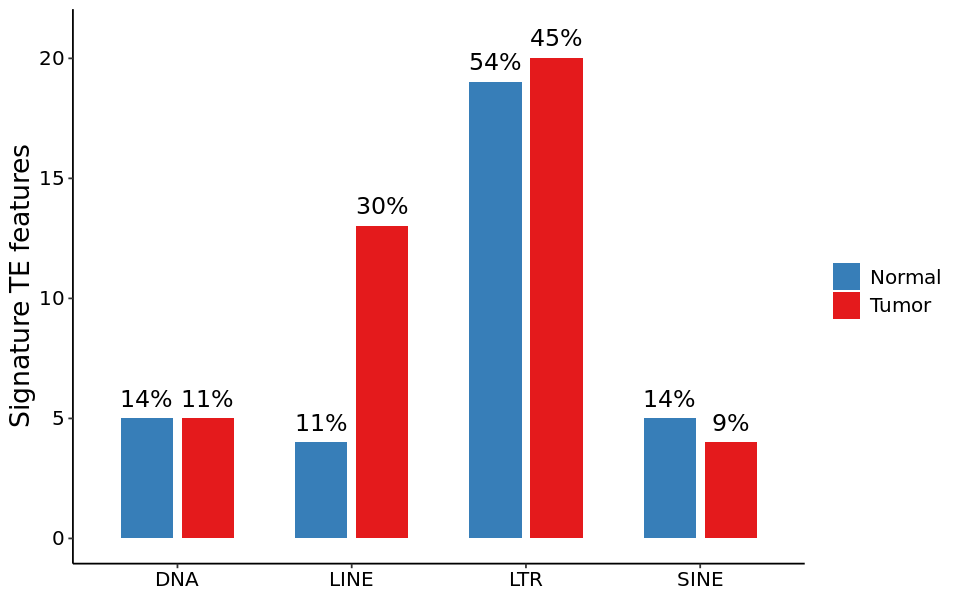

In [51]:
options(repr.plot.width = 8, repr.plot.height = 5)
ggplot(signtable[class %in% c('DNA','LINE','SINE','LTR')], aes(class, count, fill = identity)) +
geom_col(position = position_dodge(width = .7), width = .6) +
geom_text(aes(label = paste0(round(prop*100), '%')), position = position_dodge(width = .7), vjust = -0.7, size = 5) +
ylim(0,21) +
ylab('Signature TE features') +
scale_fill_manual(values = rev(brewer.pal(3, 'Set1')[1:2])) +
theme_classic() +
theme(legend.text = element_text(size = 12),
      legend.title = element_blank(),
      axis.text = element_text(colour = 'black', size = 12),
      axis.title.x = element_blank(),
      axis.title.y = element_text(size = 16))

In [61]:
for (c in c('DNA','LINE','SINE','LTR')) {
    print(prop.test(subset(signtable, class==c)$count, rep(signtable[, sum(count)], 2)))
}


	2-sample test for equality of proportions without continuity
	correction

data:  subset(signtable, class == c)$count out of rep(signtable[, sum(count)], 2)
X-squared = 0, df = 1, p-value = 1
alternative hypothesis: two.sided
95 percent confidence interval:
 -0.07593173  0.07593173
sample estimates:
    prop 1     prop 2 
0.06329114 0.06329114 


	2-sample test for equality of proportions with continuity correction

data:  subset(signtable, class == c)$count out of rep(signtable[, sum(count)], 2)
X-squared = 4.2186, df = 1, p-value = 0.03998
alternative hypothesis: two.sided
95 percent confidence interval:
 0.006279356 0.221568745
sample estimates:
    prop 1     prop 2 
0.16455696 0.05063291 



Warning message in prop.test(subset(signtable, class == c)$count, rep(signtable[, :
“Chi-squared approximation may be incorrect”



	2-sample test for equality of proportions with continuity correction

data:  subset(signtable, class == c)$count out of rep(signtable[, sum(count)], 2)
X-squared = 0, df = 1, p-value = 1
alternative hypothesis: two.sided
95 percent confidence interval:
 -0.07225117  0.09756762
sample estimates:
    prop 1     prop 2 
0.06329114 0.05063291 


	2-sample test for equality of proportions with continuity correction

data:  subset(signtable, class == c)$count out of rep(signtable[, sum(count)], 2)
X-squared = 0, df = 1, p-value = 1
alternative hypothesis: two.sided
95 percent confidence interval:
 -0.1344471  0.1597636
sample estimates:
   prop 1    prop 2 
0.2531646 0.2405063 



In [119]:
# Count tumor- or normal-specific LINE1 subfamilies by clade
teclades <- tetable[
    family=='L1' & subfamily %in% c(Ksignature, Nsignature),
    .(identity = ifelse(subfamily %in% Ksignature, 'Tumor', 'Normal'), subfamily)
][
    !is.na(identity),
    .(subfamily, identity)
][
    order(identity, subfamily),
    clade := fcase(subfamily %like% '^L1M', 'Mammals',
                   subfamily %like% '^L1P(A[16-9]|[^A])', 'Primates',
                   subfamily %like% '^L1PA[2-3]', 'Apes',
                   subfamily == 'L1HS', 'Human')
]
print(teclades)

    subfamily identity    clade
 1:      L1HS    Tumor    Human
 2:      L1M1    Tumor  Mammals
 3:     L1M4b    Tumor  Mammals
 4:     L1M4c   Normal  Mammals
 5:     L1MA9   Normal  Mammals
 6:     L1MB2    Tumor  Mammals
 7:    L1MC4a    Tumor  Mammals
 8:     L1MCa   Normal  Mammals
 9:     L1MD3    Tumor  Mammals
10:     L1ME5    Tumor  Mammals
11:      L1P3    Tumor Primates
12:    L1PA17    Tumor Primates
13:     L1PA2    Tumor     Apes
14:     L1PA3    Tumor     Apes
15:     L1PA6    Tumor Primates
16:   L1PREC2   Normal Primates


In [120]:
table(teclades[, .(identity, clade)])

        clade
identity Apes Human Mammals Primates
  Normal    0     0       3        1
  Tumor     2     1       6        3

In [62]:
kong <- c('L1HS','L1PA2','L1PBa1','HERV1-I-int','HERV9-int','HERVH-int','LTR12D','LTR75_1','LTR7Y','MER57F','MER57-int','HERVK11D-int','HERVL18-int','MLT1G1-int','MER75','MER1B')
zhu <- c('MER57F')

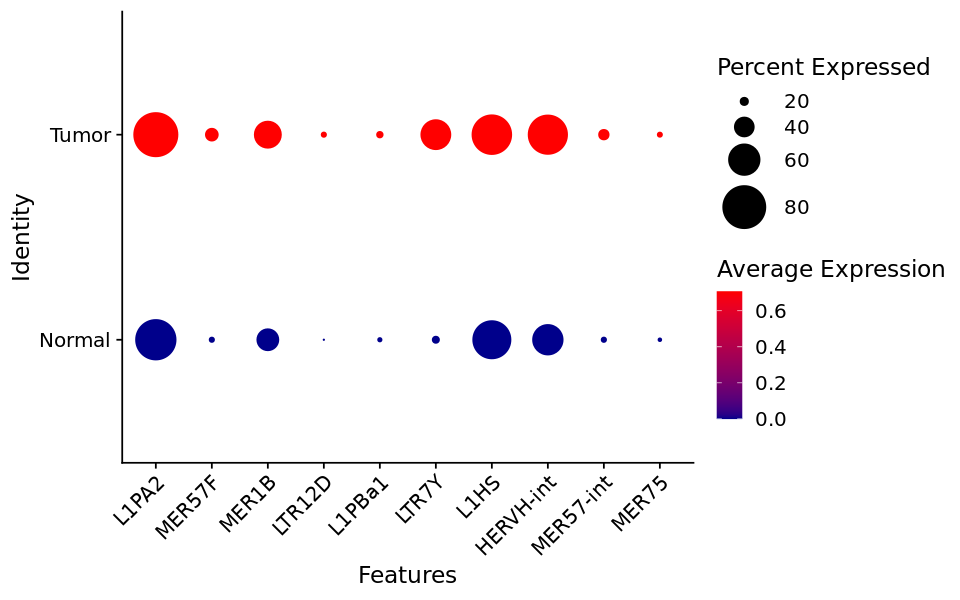

In [63]:
options(repr.plot.width = 8, repr.plot.height = 5)
DotPlot(crc, assay = 'TE', features = cluster_markers[ gene %in% c(kong, zhu) , unique(gene)], col.min = 0, group.by = 'Class',cols = c('darkblue','red'), dot.scale = 12) + RotatedAxis()

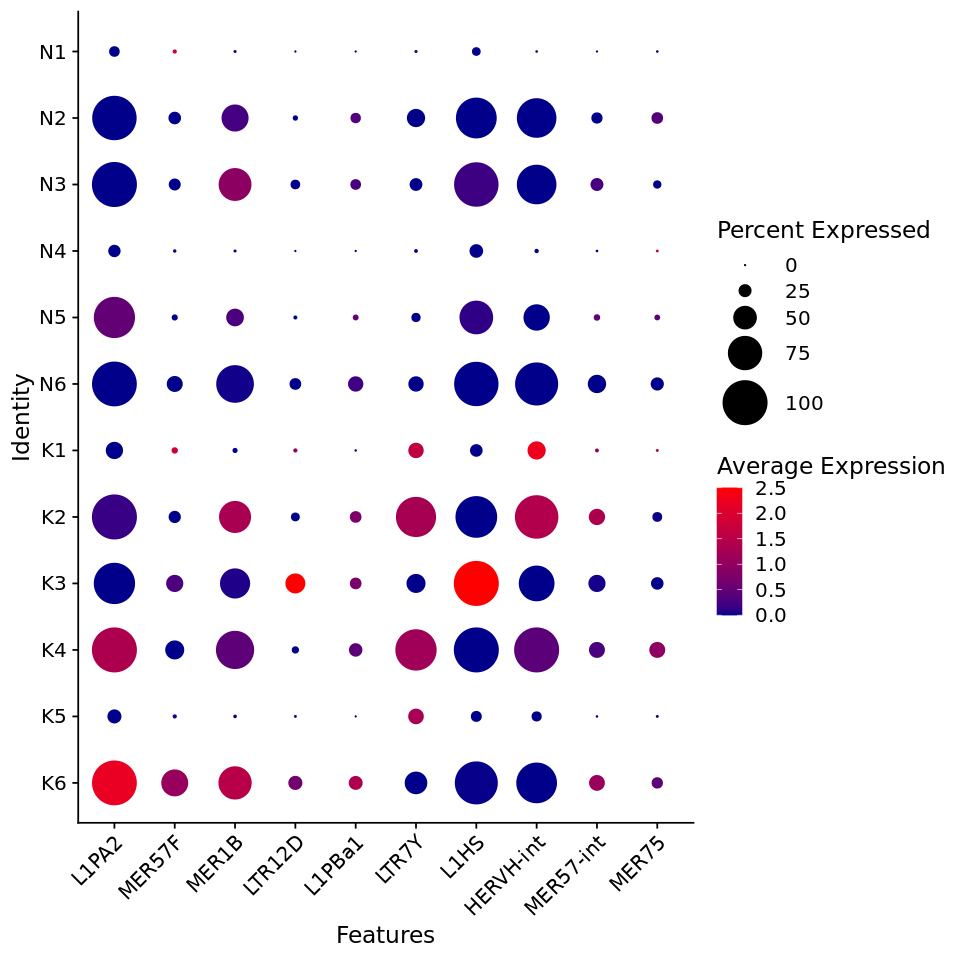

In [64]:
options(repr.plot.width = 8, repr.plot.height = 8)
DotPlot(crc, assay = 'TE', features = cluster_markers[ gene %in% c(kong, zhu) , unique(gene)], group.by = 'te.clusters', col.min = 0, cols = c('darkblue','red'), dot.scale = 12) + RotatedAxis()

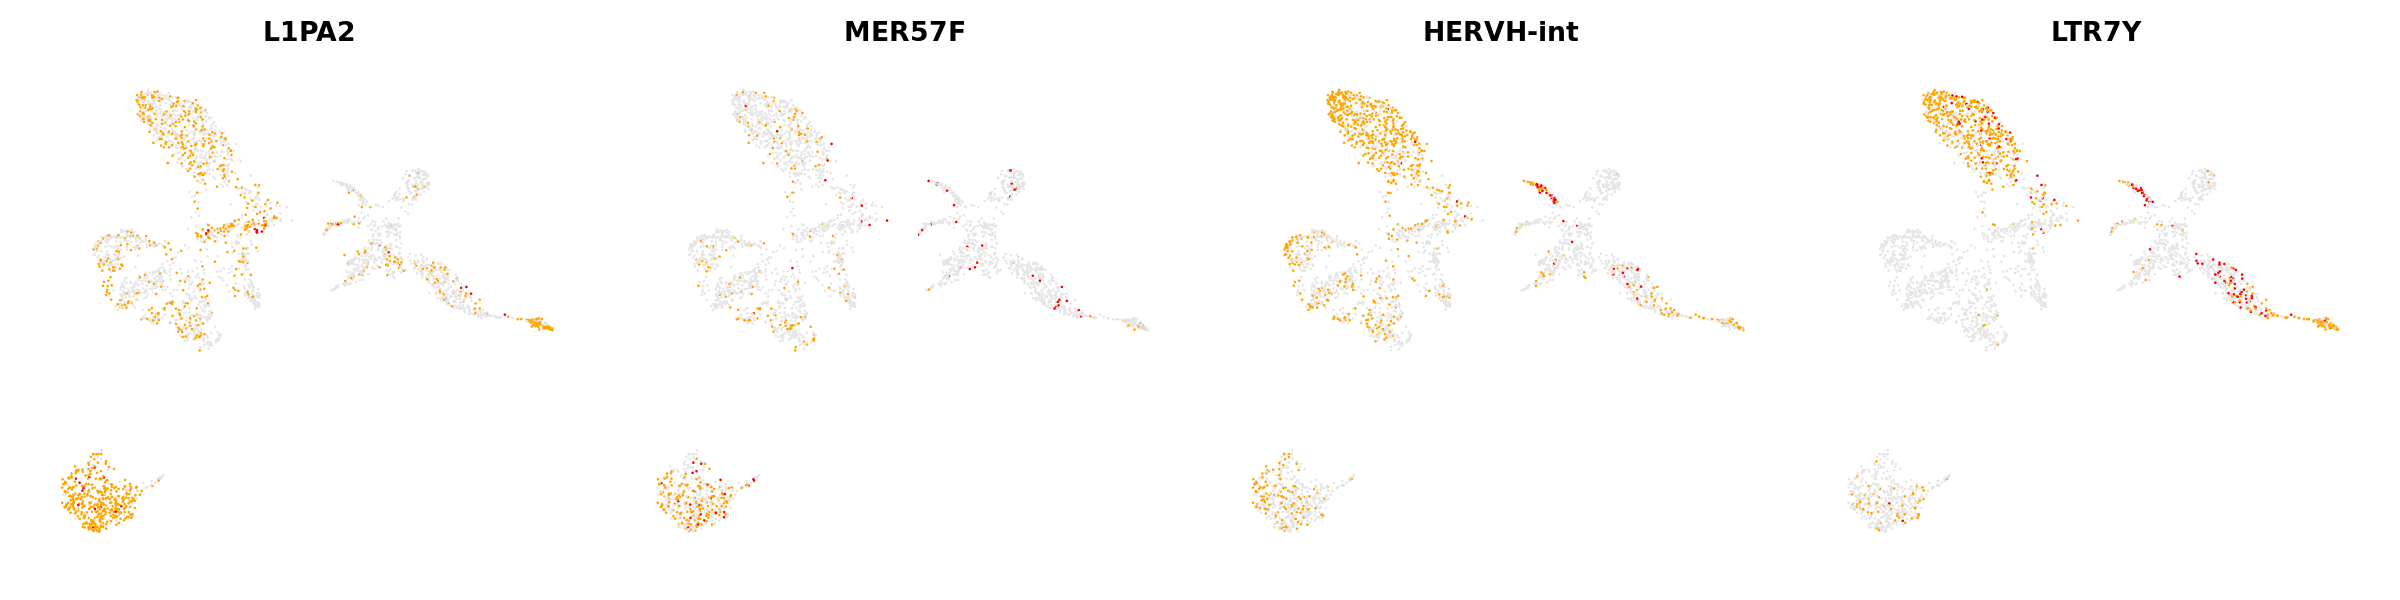

In [65]:
options(repr.plot.width = 20, repr.plot.height = 5)
FeaturePlot(crc, 'L1PA2', reduction = 'te.umap', pt.size = .1, cols = c("gray90", "orange", "red"), slot = 'data', min.cutoff = 2) + NoLegend() + NoAxes() |
FeaturePlot(crc, 'MER57F', reduction = 'te.umap', pt.size = .1, cols = c("gray90", "orange", "red"), slot = 'data', max.cutoff = 3) + NoLegend() + NoAxes() |
FeaturePlot(crc, 'HERVH-int', reduction = 'te.umap', pt.size = .1, cols = c("gray90", "orange", "red"), slot = 'data', min.cutoff = 1) + NoLegend() + NoAxes() |
FeaturePlot(crc, 'LTR7Y', reduction = 'te.umap', pt.size = .1, cols = c("gray90", "orange", "red"), slot = 'data') + NoLegend() + NoAxes()